In [1]:
pip --version

pip 20.0.2 from /Users/jbanerje/opt/anaconda3/lib/python3.7/site-packages/pip (python 3.7)
Note: you may need to restart the kernel to use updated packages.


In [2]:
%%capture
pip install prometheus-api-client

In [3]:
%%capture
pip install matplotlib

In [4]:
from prometheus_api_client import *
import matplotlib.pyplot as plt
import os
import numpy as np
import sys
import datetime
import pandas
import seaborn as sns
# Set default Seaborn style
sns.set(style="darkgrid")
sns.set_context("talk", font_scale=1.4)
## hides ipython warnings
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (30, 10)
#plt.rcParams['figure.figsize'] = (20, 5)

# This is still experimental :

Trying to look at various data points (same metric) across different clusters. The goal is to see if we can programmatically determine how similar or dissimilar they are. Visually its easy.

## To set up

1. If you set live_analysis = False, this notebook will load data from csv in this git repo.
1. If you set live_analysis = True, then continue to read:
    1. Install ACM and Observability
    1. Get URL of the route called rbac-query-proxy created in namespace:open-cluster-management-observability
    1. Get the bearer token of the logged in user
    1. Select the time range in the cell below

## If you run this notebook

Programmatically determine how similar or dissimilar the time series are


### Set true if we are connecting live else it will load data from csv


In [5]:
live_analysis = False

### Sets the connection details - ignored if live_analysis is False

In [6]:
# URL of the route call rbac-query-proxy 
# created in namespace:open-cluster-management-observability
# after installing Observability on Advanaced Cluster Managment Install
url = "https://rbac-query-proxy-open-cluster-management-observability.apps.xyz.redhat.com/"
# bearer token obtained from command `oc whoami -t`
token = "sha256~5AyxhxNb4voPuT0galw4X-abcd1234xyz"
#connects to Thanos or Prometheus as dictated by the URL
pc = PrometheusConnect(url=url, headers={"Authorization": "Bearer {}".format(token)}, disable_ssl=True);

### Sets the time range and time step for all queries below - ignored if live_analysis is False

In [7]:
start_time=(datetime.datetime.now() - datetime.timedelta(minutes=2160))
end_time=datetime.datetime.now()
#interval between data points gathered
step='10m'

In [8]:
if live_analysis:
    # PromQL being run: node_namespace_pod_container:container_cpu_usage_seconds_total:sum_rate{namespace="open-cluster-management-addon-observability",container="metrics-collector"}
    metric_total = pc.custom_query_range(
        query='node_namespace_pod_container:container_cpu_usage_seconds_total:sum_rate{namespace="open-cluster-management-addon-observability",container="metrics-collector"}',
        start_time=start_time,
        end_time=end_time,
        step=step,
    )

    metric_total_df = MetricRangeDataFrame(metric_total);
    metric_total_df["value"]=metric_total_df["value"].astype(float)
    metric_total_df.index= pandas.to_datetime(metric_total_df.index, unit="s")

    # Saves the data in path /Users/jbanerje/code/multicluster-notebooks/data/metric-collector.csv
    #metric_total_df.to_csv (r'/Users/jbanerje/code/multicluster-notebooks/data/metric-collector.csv', index = True, header=True)

else:
    fname = os.path.join("data","metric-collector.csv.gz")
    metric_total_df = pandas.read_csv(fname,index_col=0,compression='gzip')
    # if the file is not gz, then command is: metric_total_df = pandas.read_csv(fname,index_col=0)
    metric_total_df["value"]=metric_total_df["value"].astype(float)
    #print(metric_total_df.head())
    print(metric_total_df.count())





__name__       397280
cluster        397280
clusterID      397280
container      397280
namespace      397280
node           397280
pod            397280
receive        397280
tenant_id      397280
value          397280
clusterType    397157
dtype: int64


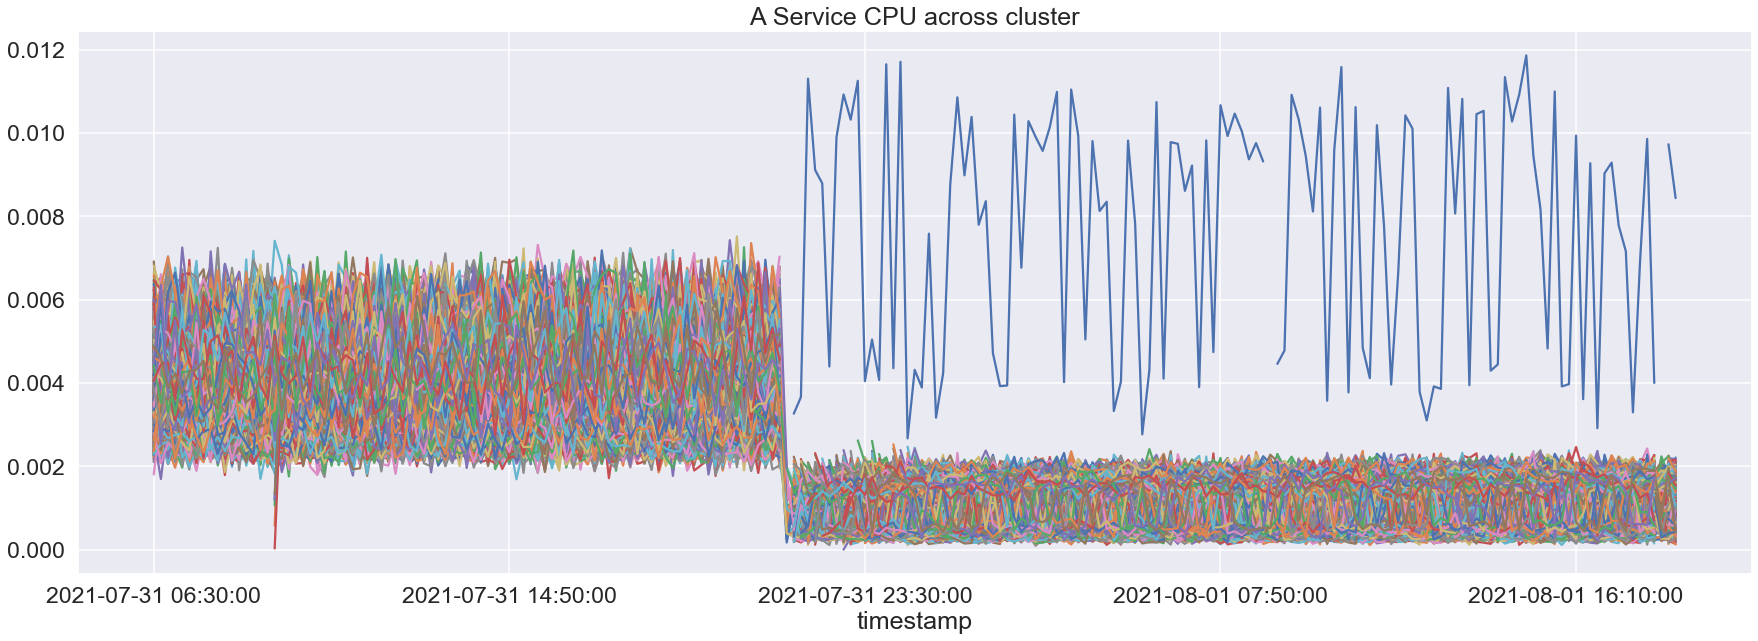

In [9]:
ametric_cluster_df = metric_total_df.groupby(["cluster","timestamp"])["value"].sum()
ametric_cluster_df=ametric_cluster_df.unstack(level=0)
#print(ametric_cluster_df.head())
ax=ametric_cluster_df.plot(title="A Service CPU across cluster")
ax.legend(bbox_to_anchor=(0., 1.06, 1., .102), loc='lower left', ncol=6, mode="expand", borderaxespad=0.)
#just removing the legend from being print
#its meaningless to show 1k labels
ax.get_legend().remove()
plt.show()

[]

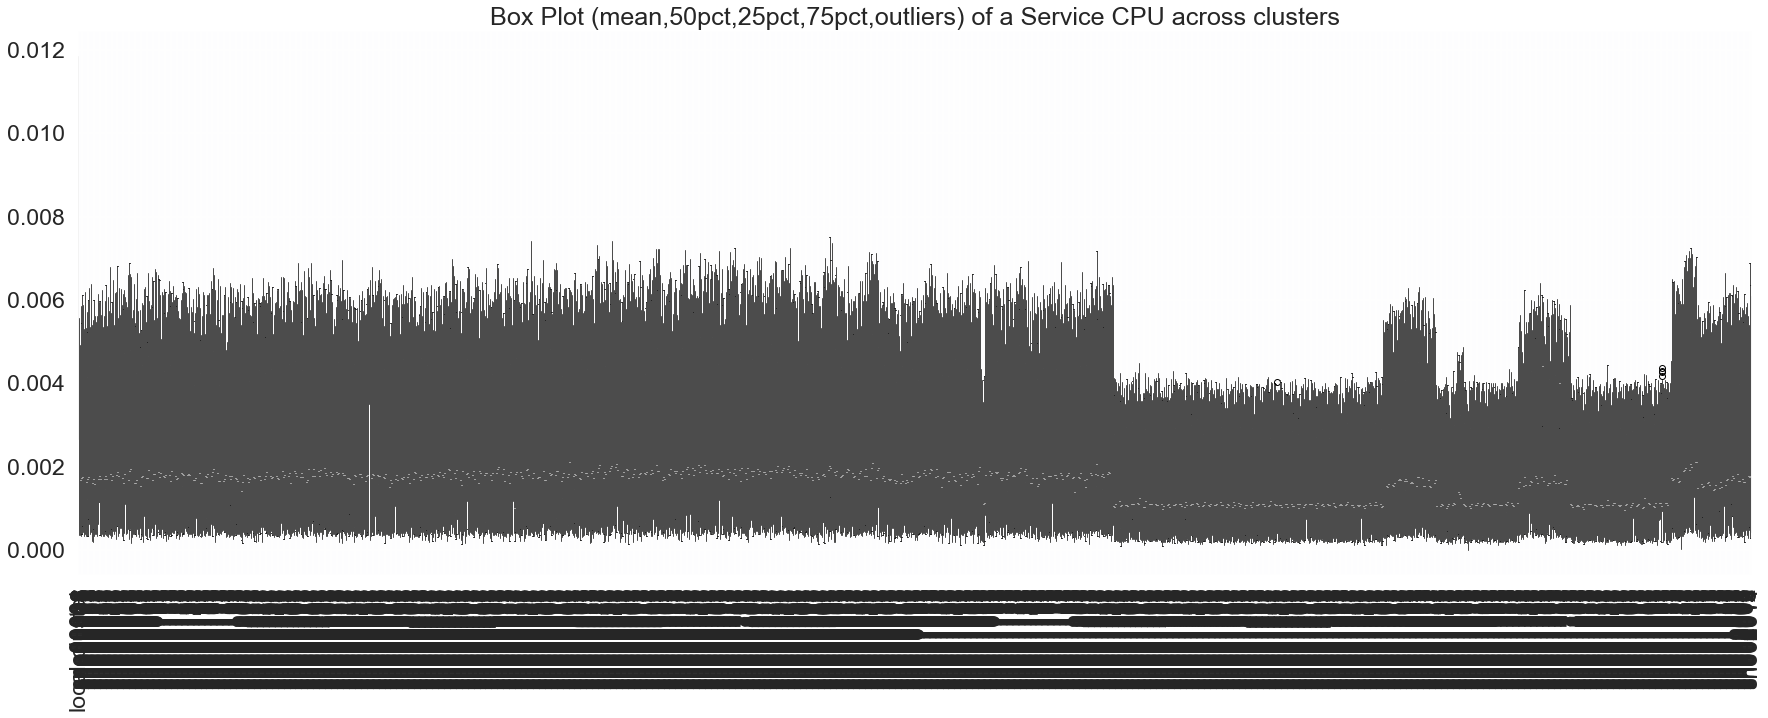

In [10]:
boxplot = ametric_cluster_df.boxplot()
plt.title("Box Plot (mean,50pct,25pct,75pct,outliers) of a Service CPU across clusters")
plt.xticks(rotation=90)
boxplot.plot()


In [11]:
if live_analysis:
    # PromQL being run: container_memory_working_set_bytes{namespace="open-cluster-management-addon-observability",container="metrics-collector"}
    metric_mem_total = pc.custom_query_range(
        query='container_memory_working_set_bytes{namespace="open-cluster-management-addon-observability",container="metrics-collector"}',
        start_time=start_time,
        end_time=end_time,
        step=step,
    )

    metric_mem_total_df = MetricRangeDataFrame(metric_mem_total);
    metric_mem_total_df["value"]=metric_mem_total_df["value"].astype(float)
    metric_mem_total_df.index= pandas.to_datetime(metric_mem_total_df.index, unit="s")
    
    # Saves the data in path /Users/jbanerje/code/multicluster-notebooks/data/metric-collector.csv
    #metric_mem_total_df.to_csv (r'/Users/jbanerje/code/multicluster-notebooks/data/metric-collector-memory.csv', index = True, header=True)

else:
    fname = os.path.join("data","metric-collector-memory.csv.gz")
    metric_mem_total_df = pandas.read_csv(fname,index_col=0,compression='gzip')
    # if the file is not gz, then command is: metric_mem_total_df = pandas.read_csv(fname,index_col=0)
    metric_mem_total_df["value"]=metric_mem_total_df["value"].astype(float)
    
    #print(metric_mem_total_df.head())
    print(metric_mem_total_df.count())



__name__        398212
cluster         398212
clusterID       398212
container       398212
endpoint        398212
id              398212
image           398212
instance        398212
job             398212
metrics_path    398212
name            398212
namespace       398212
node            398212
pod             398212
receive         398212
service         398212
tenant_id       398212
value           398212
clusterType     398091
dtype: int64


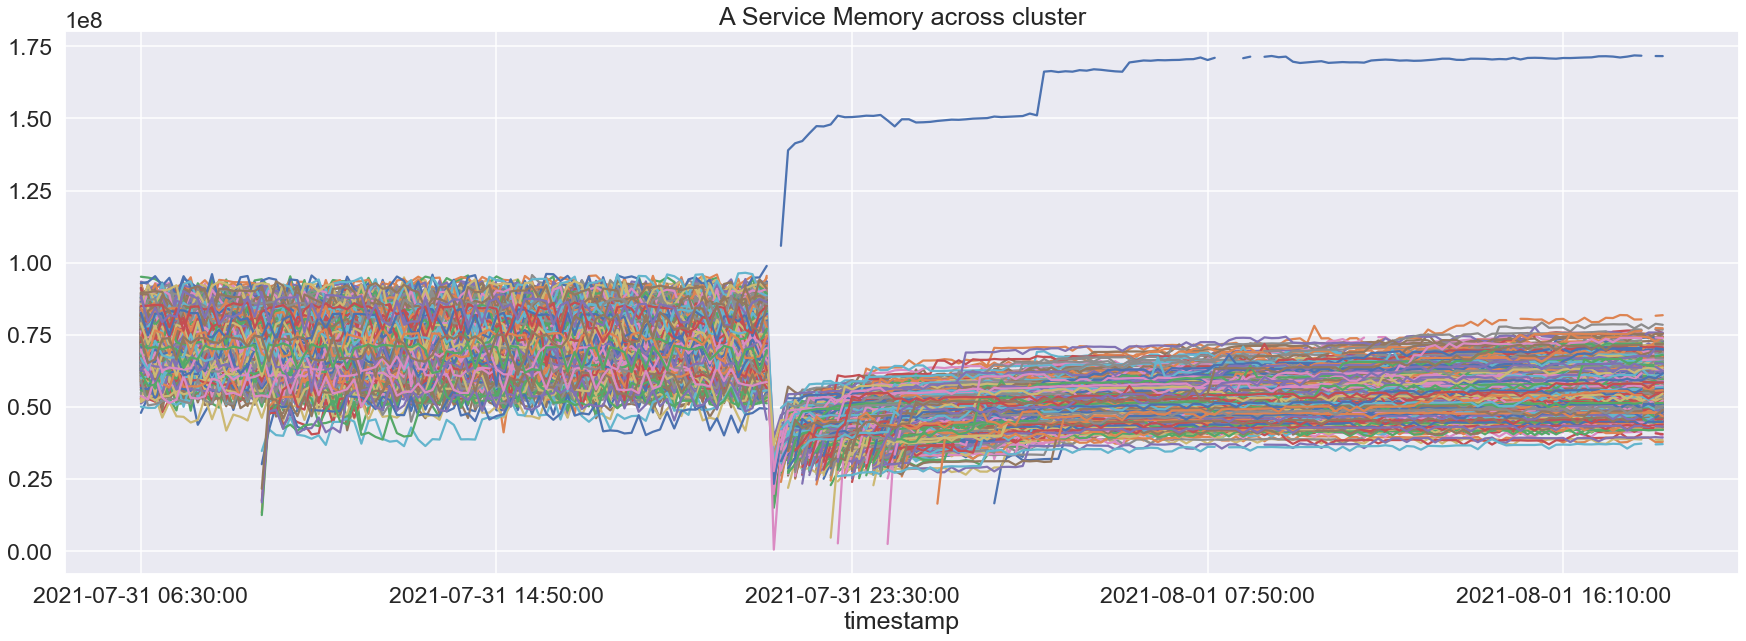

In [12]:
bmetric_cluster_df = metric_mem_total_df.groupby(["cluster","timestamp"])["value"].sum()
bmetric_cluster_df=bmetric_cluster_df.unstack(level=0)
#print(bmetric_cluster_df.head())
ax=bmetric_cluster_df.plot(title="A Service Memory across cluster")
ax.legend(bbox_to_anchor=(0., 1.06, 1., .102), loc='lower left', ncol=6, mode="expand", borderaxespad=0.)
#just removing the legend from being print
#its meaningless to show 1k labels
ax.get_legend().remove()
plt.show()

[]

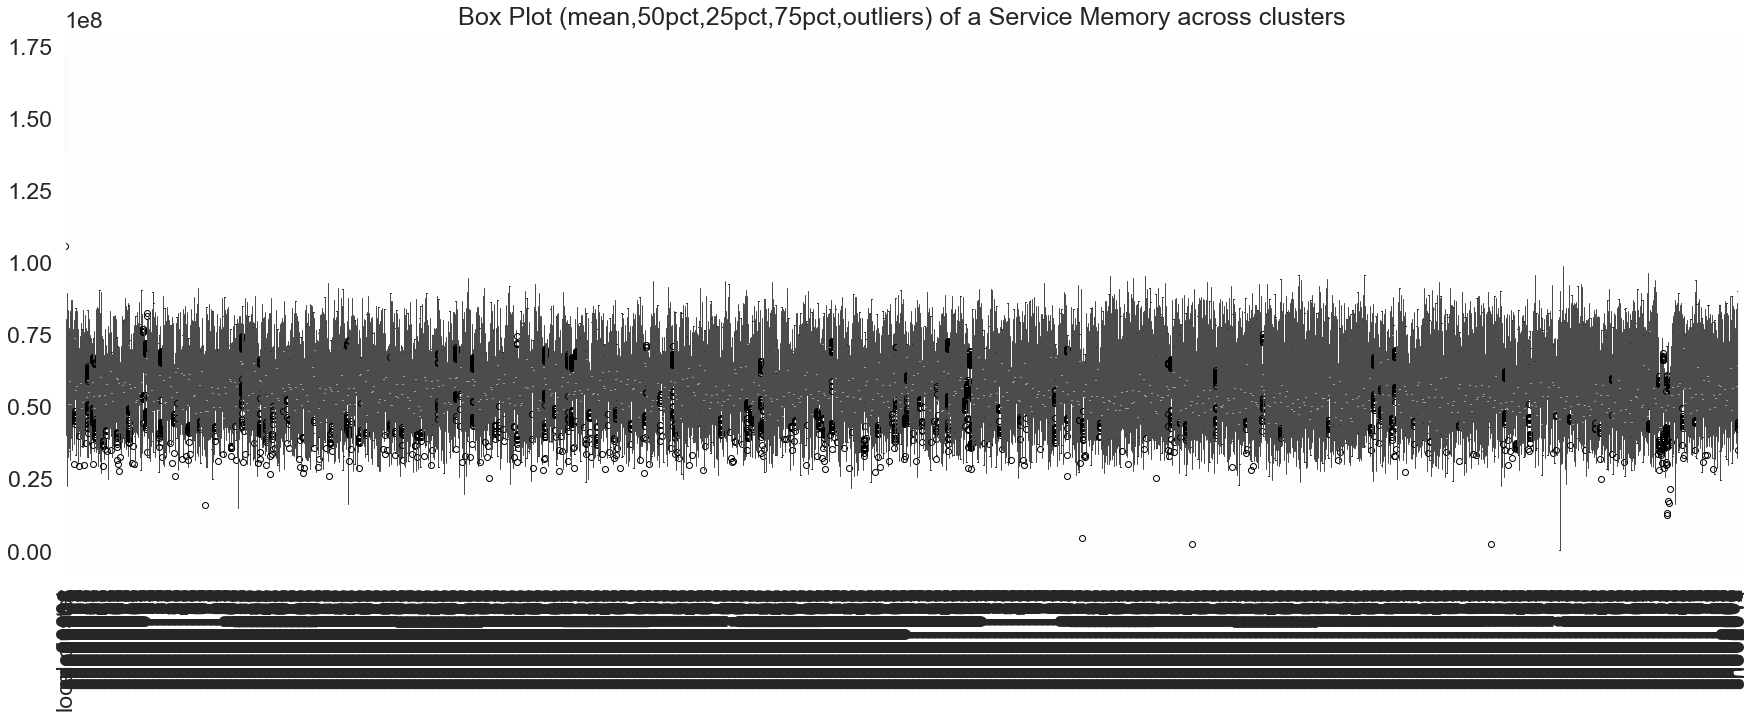

In [13]:
boxplot = bmetric_cluster_df.boxplot()
plt.title("Box Plot (mean,50pct,25pct,75pct,outliers) of a Service Memory across clusters")
plt.xticks(rotation=90)
boxplot.plot()

In [14]:
if live_analysis:
    node_cpu_utilisation_rate = pc.custom_query_range(
        query='instance:node_cpu_utilisation:rate1m{job="node-exporter",cluster!="local-cluster"}*100',
        start_time=start_time,
        end_time=end_time,
        step=step,
    )

    node_cpu_metric_df = MetricRangeDataFrame(node_cpu_utilisation_rate);
    node_cpu_metric_df["value"]=node_cpu_metric_df["value"].astype(float)
    node_cpu_metric_df.index= pandas.to_datetime(node_cpu_metric_df.index, unit="s")
    
    # Saves the data in path /Users/jbanerje/code/multicluster-notebooks/data/sno-node-cpu.csv
    #node_cpu_metric_df.to_csv (r'/Users/jbanerje/code/multicluster-notebooks/data/sno-node-cpu.csv', index = True, header=True)

else:
    fname = os.path.join("data","sno-node-cpu.csv.gz")
    node_cpu_metric_df = pandas.read_csv(fname,index_col=0,compression='gzip')
    # if the file is not gz, then command is: node_cpu_metric_df = pandas.read_csv(fname,index_col=0)
    node_cpu_metric_df["value"]=node_cpu_metric_df["value"].astype(float)

    #print(node_cpu_metric_df.head())



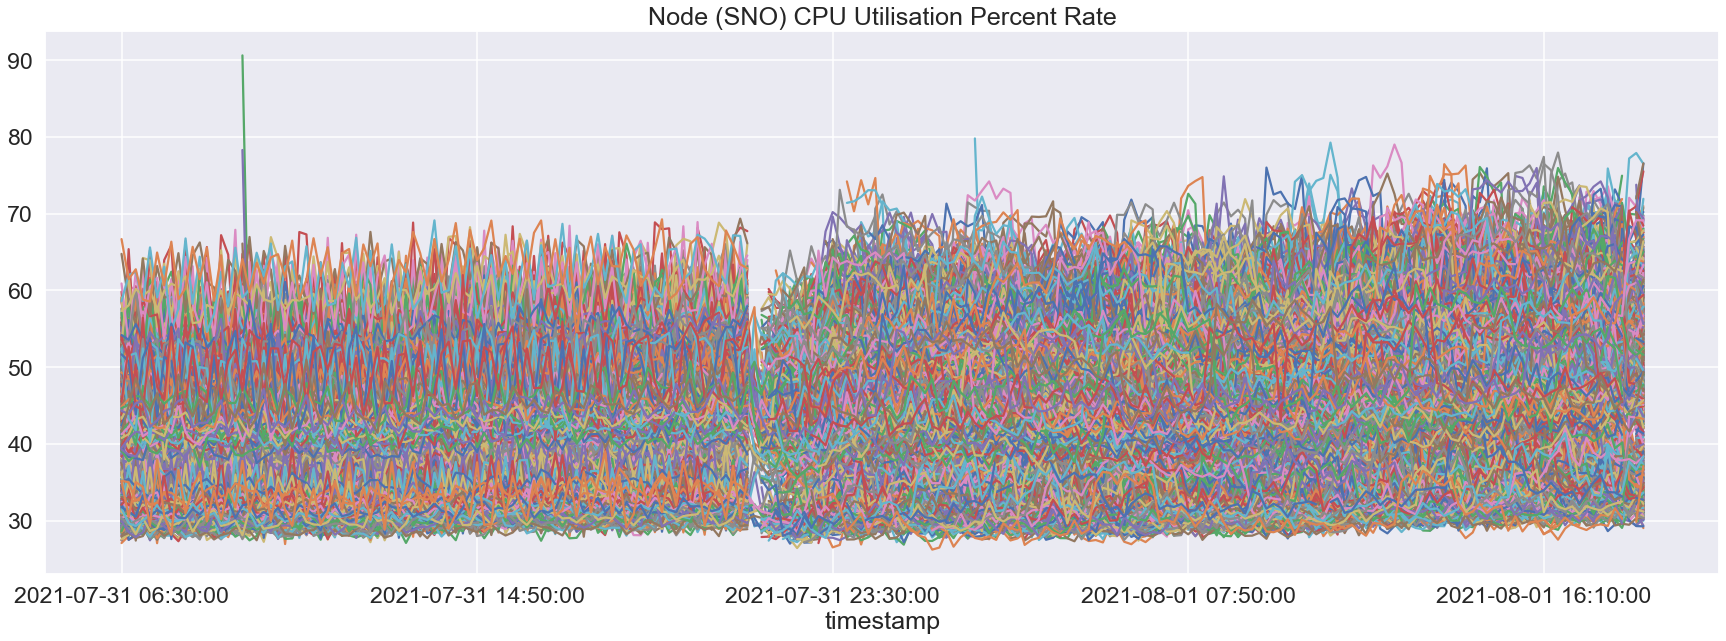

In [15]:
df = node_cpu_metric_df.pivot( columns='instance',values='value')
ax=df.plot(title="Node (SNO) CPU Utilisation Percent Rate")
ax.legend(bbox_to_anchor=(0., 1.06, 1., .102), loc='lower left', ncol=2, mode="expand", borderaxespad=0.)
#plt.legend(loc='lower left',ncol=3)
ax.get_legend().remove()
plt.show()
#print(df.head(5))


[]

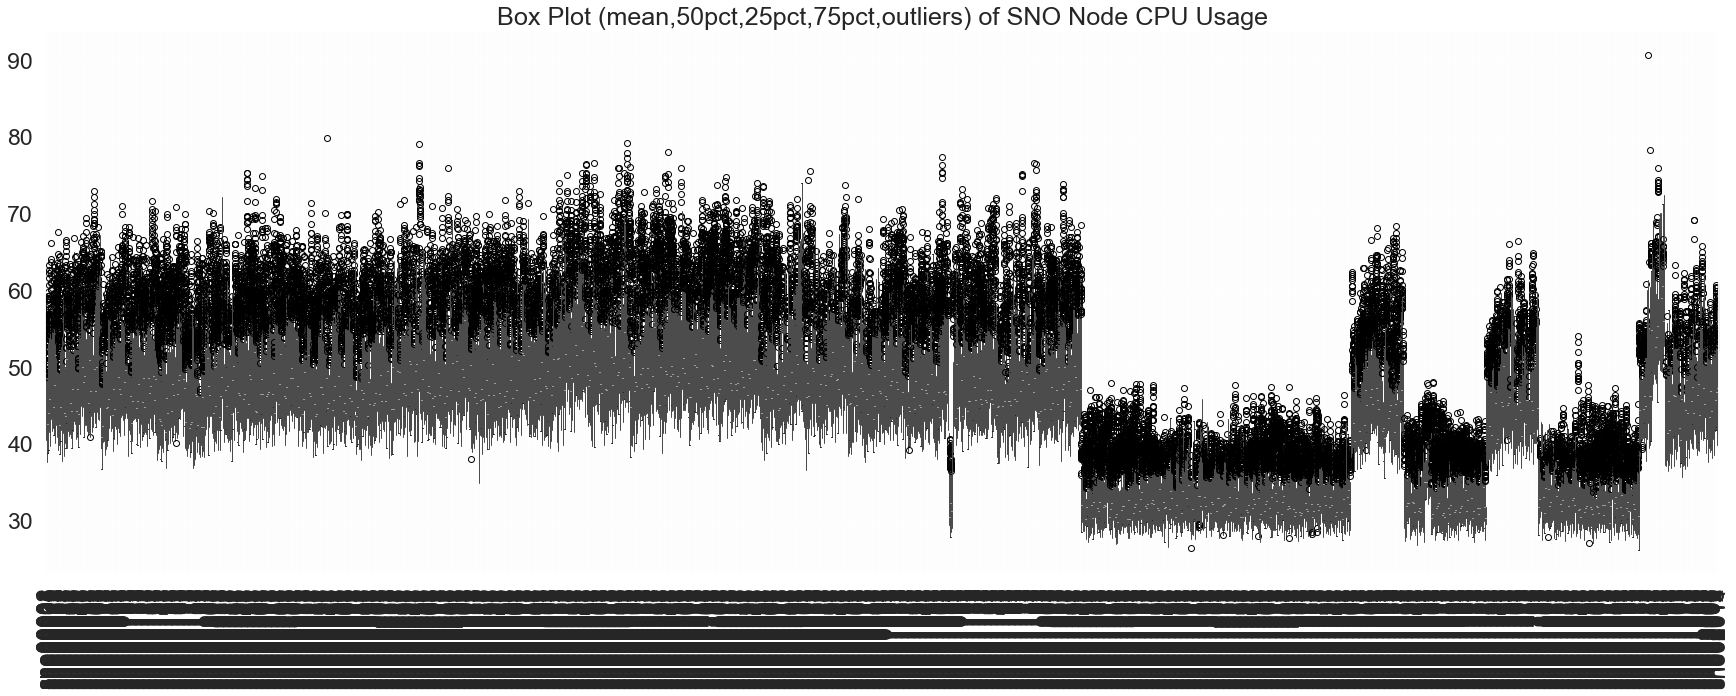

In [16]:
boxplot = df.boxplot()
plt.title("Box Plot (mean,50pct,25pct,75pct,outliers) of SNO Node CPU Usage")
plt.xticks(rotation=90)
boxplot.plot()



<class 'pandas.core.frame.DataFrame'>
Index: 1956 entries, sno00001 to sno02014
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (value, count)  1956 non-null   float64
 1   (value, mean)   1956 non-null   float64
 2   (value, std)    1956 non-null   float64
 3   (value, min)    1956 non-null   float64
 4   (value, 25%)    1956 non-null   float64
 5   (value, 50%)    1956 non-null   float64
 6   (value, 75%)    1956 non-null   float64
 7   (value, max)    1956 non-null   float64
dtypes: float64(8)
memory usage: 137.5+ KB
None


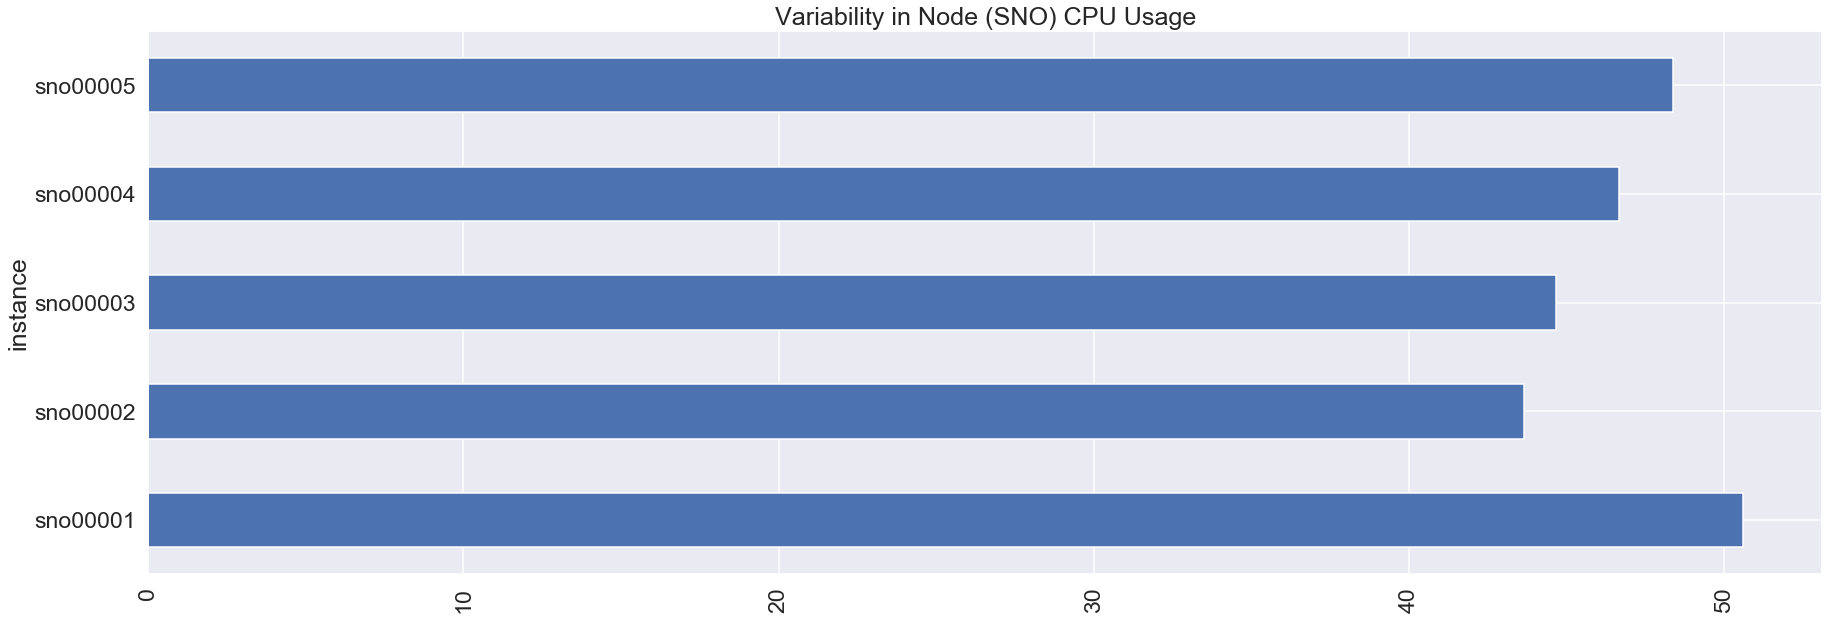

In [17]:
node_summary_stats=node_cpu_metric_df.groupby(["instance"])[["value"]].describe()
print(node_summary_stats.info())
#print(node_summary_stats["value", "75%"].head())

#CANNOT draw all values in this graph. Too many data points. So just trying head()
ax = node_summary_stats["value", "75%"].head().plot.barh(x='cpu-util', y='value', rot=0)

#f, ax = plt.subplots()
#ax.bar(node_summary_stats.index, node_summary_stats["value", "75%"], color="red", width=0.05)

ax.set(title="Variability in Node (SNO) CPU Usage")
plt.xticks(rotation=90)
plt.show()